<a href="https://colab.research.google.com/github/AlenaPotato/pet_projects/blob/main/Time_series_project/energy_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек



In [2]:
# Для работы с данными
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Регрессии
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Метрики
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Для оценки временного ряда
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Прочее
import itertools
import warnings
warnings.filterwarnings("ignore")

# Загрузка данных


Данные взяты с сайта Kaggle https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

In [3]:
# Загрузка файл kaggle.json в Colab:
from google.colab import files
files.upload()

# Установка Kaggle API:
!pip install kaggle

# Создание папки и перемещение файла kaggle.json в папку:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Настройка прав доступа к файлу:
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [4]:
# Скачивание данных из Kaggle:
!kaggle datasets download -d robikscube/hourly-energy-consumption

# Разархивация файла:
!unzip hourly-energy-consumption.zip

Dataset URL: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
License(s): CC0-1.0
hourly-energy-consumption.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  hourly-energy-consumption.zip
replace AEP_hourly.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [11]:
# Загрузка данных в DataFrame
df = pd.read_csv('AEP_hourly.csv')
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


# Предварительная обработка данных


In [12]:
df.rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])

df.head()

,ds,y
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [14]:
# Проверка наличия пропусков
print(df.isnull().sum())

ds    0
y     0
dtype: int64


# Анализ временного ряда


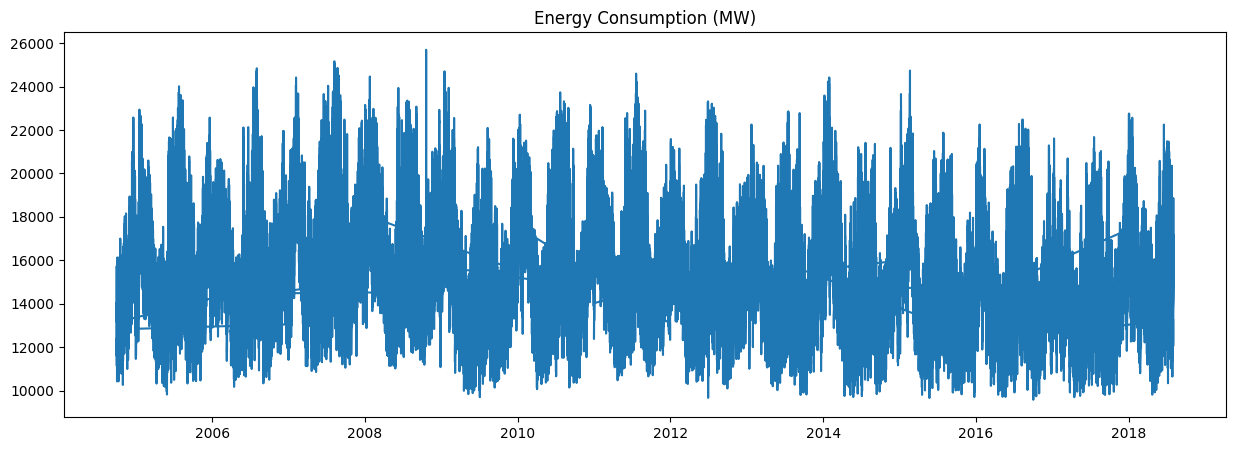

In [15]:
# Построение ряда
plt.figure(figsize=(15, 5))
plt.plot(df['ds'], df['y'])
plt.title('Energy Consumption (MW)')
plt.show()

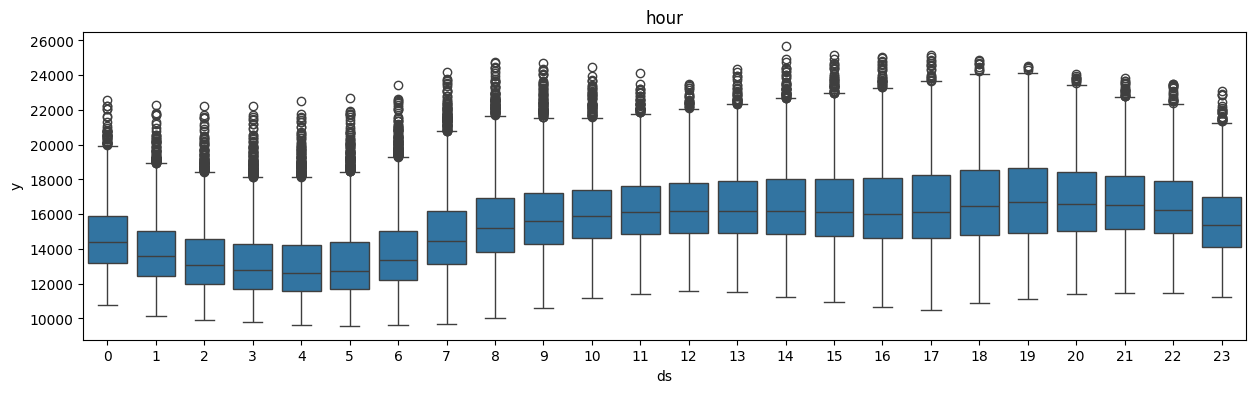

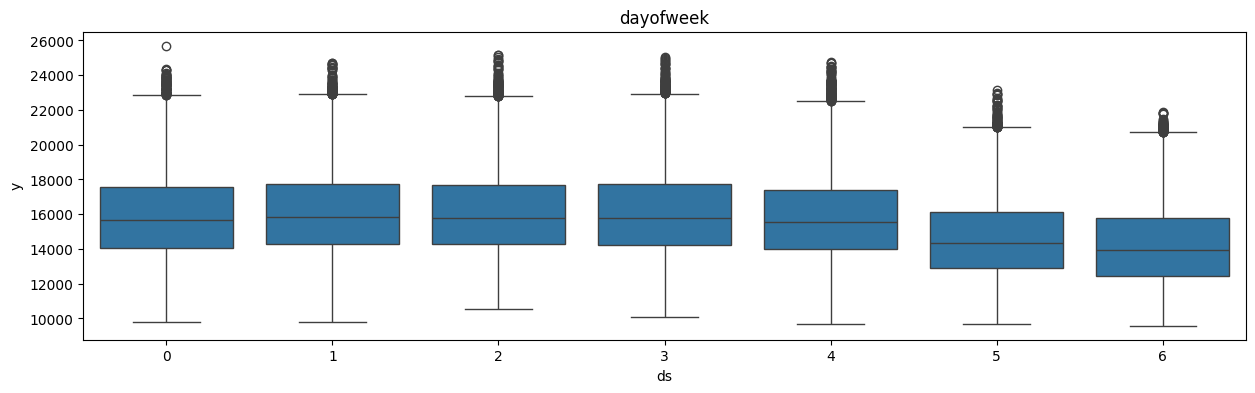

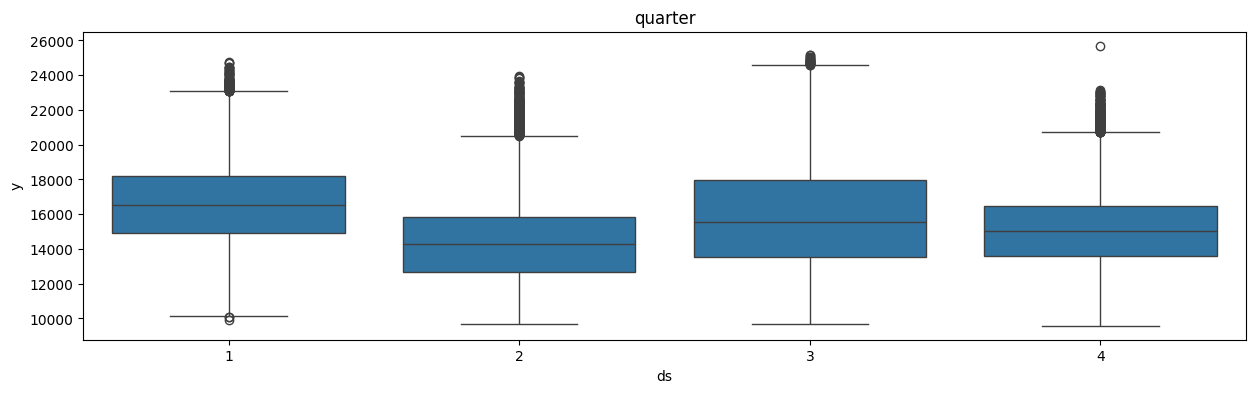

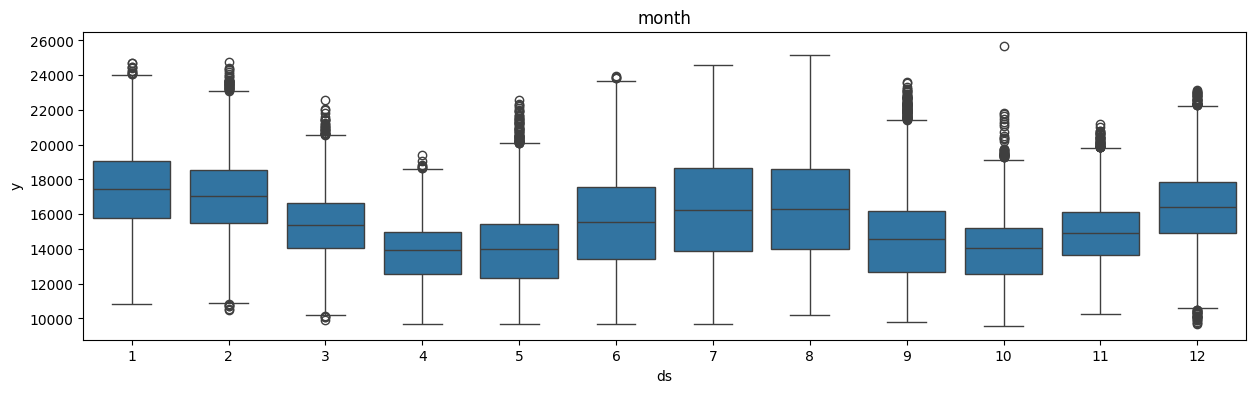

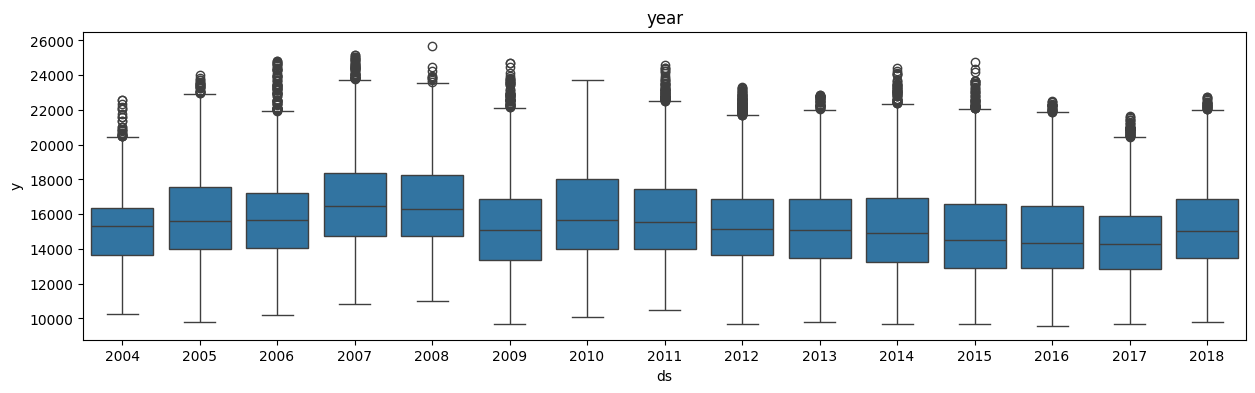

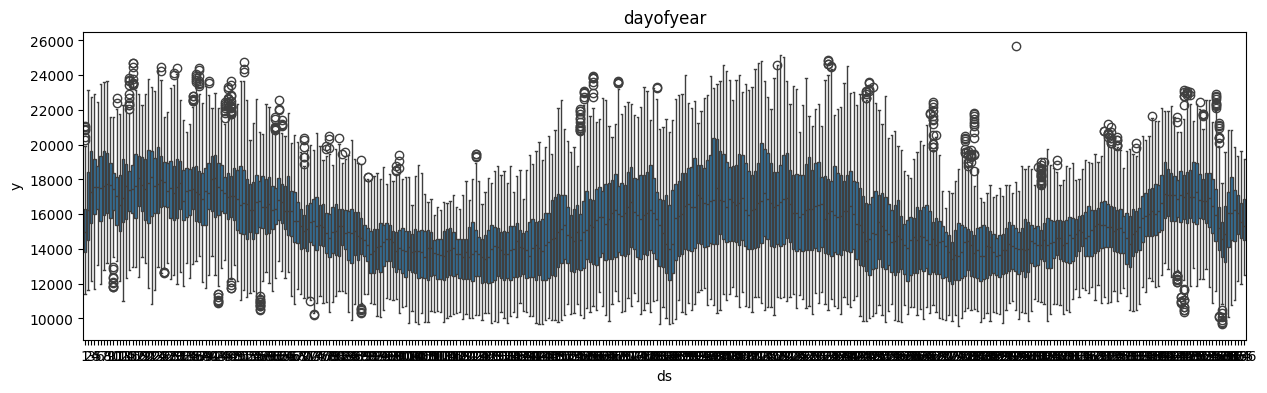

In [16]:
# Данные в разбивке по разным временным промежуткам.
periods = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
dt_period = [df['ds'].dt.hour, df['ds'].dt.dayofweek, df['ds'].dt.quarter,
             df['ds'].dt.month, df['ds'].dt.year, df['ds'].dt.dayofyear]

for i in range(len(periods)):
    plt.figure(figsize=(15, 4))
    sns.boxplot(data=df,x=dt_period[i],y='y')
    plt.title(periods[i])
    plt.show()

Из графиков боксплот можно сделать следующие заключения:
- В течение дня в вечерние часы потребление электроэнергии больше.
- На выходных (суббота и воскресенье) электроэнергии потребляется меньше.
- Потребление электроэнергии а первом и третьем квартале больше, чем во втором и четвёртом.
- В летние месяцы (июль, август), а также в зимние (декабрь, январь, февраль) потребление электроэнергии значительно выше, чем в остальные месяцы. Это согласуется с квартальными данными - летние месяца оппадают на третий квартал, зимние - на первый.
- По годам не заметен тренд на увеличение потребления электроэнергии.
- График по дням года согласуется с данными по месяцам и кварталам.

На лицо сезонность и отсутствие тренда.



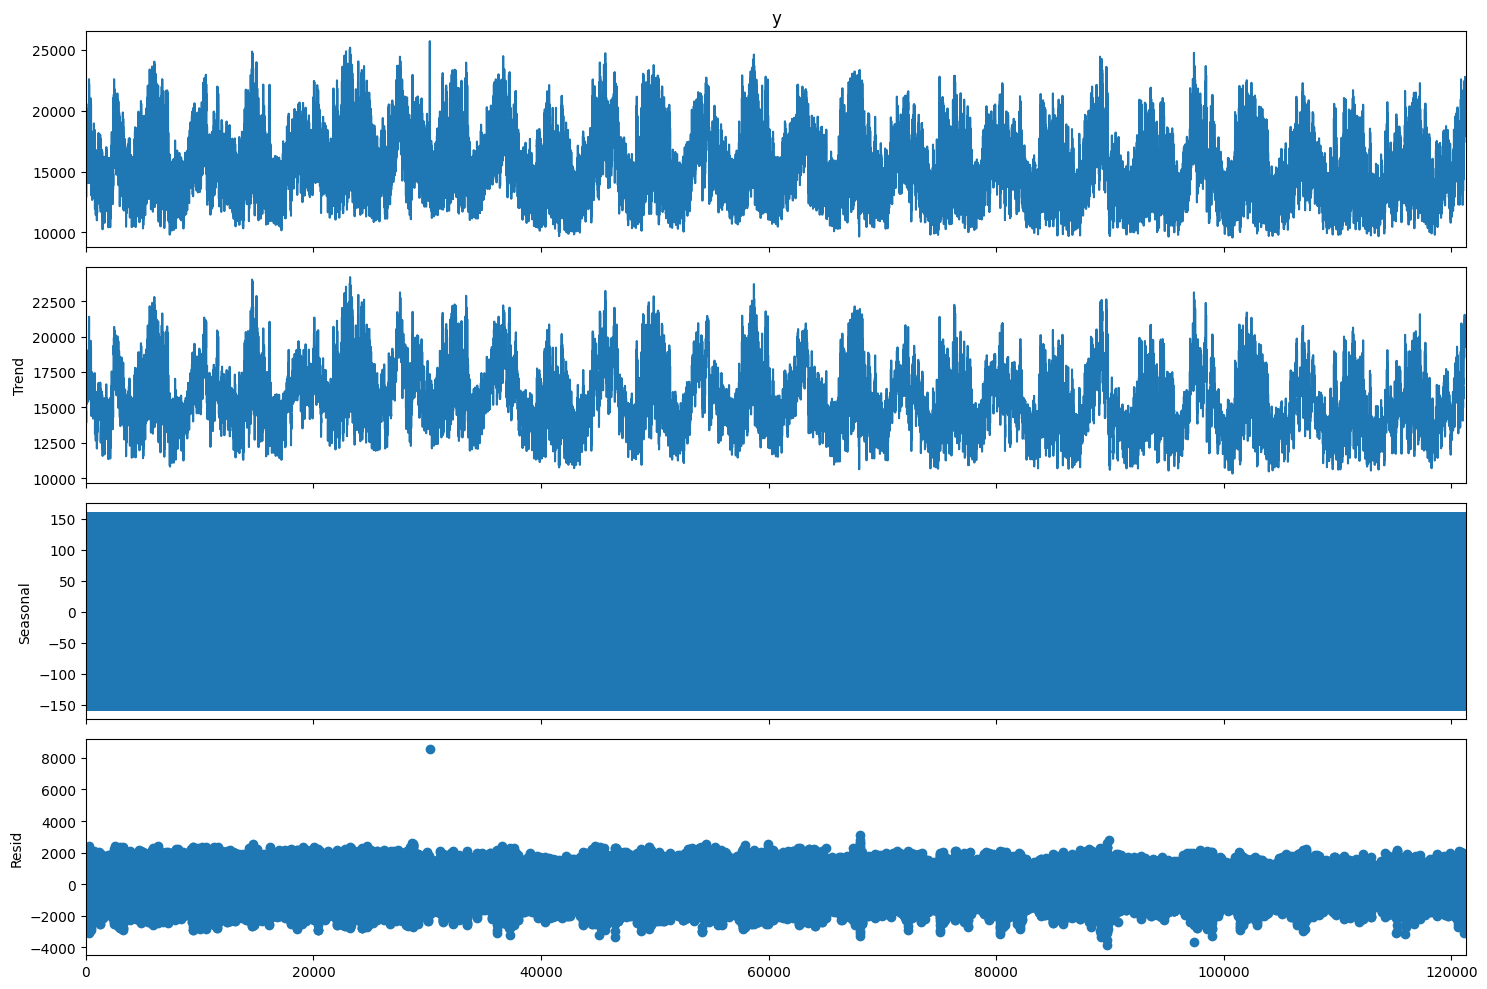

In [17]:
# Сезонная декомпозиция временного ряда
decomposition = seasonal_decompose(df['y'], model='additive', period=12)

plt.rc("figure",figsize=(15,10))
decomposition.plot()
plt.show()


Cезонная декомпозиция помогла лучше понять структуру временного ряда. График не показывает тренда, в ряду присутствует сезонность.

Ряд стационарен.


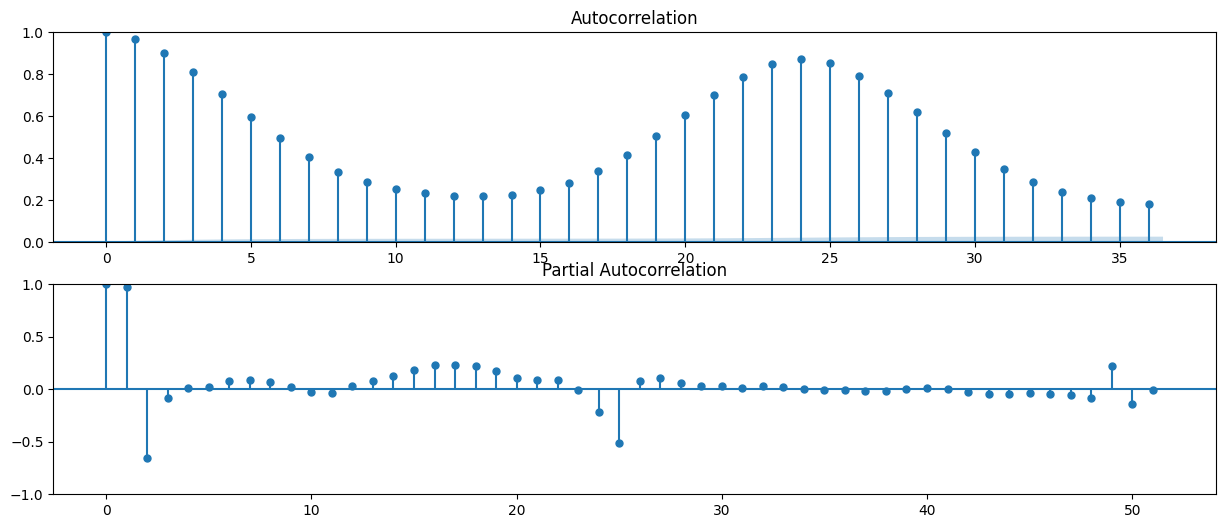

In [18]:
# Тест Дики-Фуллера
result = adfuller(df['y'])

# Н0: ряд нестационарен
# Н1: ряд стационарен

if result[1] <= 0.05:
    print('Ряд стационарен.') # H0 отвергается
else:
    print(f'Ряд нестационарен. p_value = {result[1]}')

# Графики автокорреляции и частичной автокорреляции
fig, ax = plt.subplots(2, 1, figsize=(15,6))
plot_acf(df['y'], ax=ax[0], lags=36)
ax[0].set_ylim(0, 1)
plot_pacf(df['y'], ax=ax[1])
plt.show()


Тест Дики-Фуллера говорит о том, что рассматриваемый ряд стационарен, т.е. есть повторяющийся патерн в потреблении электроэнергии.


# Обучение модели


In [19]:
# Разделение данных на тренировочные и тестовые (для моделей SARIMA и prophet)
train = df.iloc[:-365*24].dropna()
test = df.iloc[-365*24:].dropna()

Оценка линейных моделей будет происходить по одному патерну, поэтому для исключения самоповторений заавтоматизирую функцию оценки линейный регрессий.

In [20]:
def linear_reg(df):

  # Разделение данных на тренировочные и тестовые
  train = df.iloc[:-365*24].dropna()
  test = df.iloc[-365*24:].dropna()

  # Обучение линейной регрессии
  X_train = train.drop(columns=['ds', 'y'])
  y_train = train['y']
  X_test = test.drop(columns=['ds', 'y'])
  y_test = test['y']

  lr_model = LinearRegression()
  lr_model.fit(X_train, y_train)

  # Прогнозы
  y_pred_train = lr_model.predict(X_train)
  y_pred_test = lr_model.predict(X_test)

  # Оценка качества модели
  test_mae = mean_absolute_error(y_test, y_pred_test)
  test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

  print(f'Linear Regression Test MAE: {test_mae}')
  print(f'Linear Regression Test RMSE: {test_rmse}')

  plt.figure(figsize=(15, 5))
  plt.plot(test['ds'], y_test, label='Actual')
  plt.plot(test['ds'], y_pred_test, label='Forecast')
  plt.xlabel('Date')
  plt.ylabel('Energy Consumption (MW)')
  plt.title('Test Set: Actual vs Forecast (Linear Regression)')
  plt.legend()
  plt.show()

  return test_mae, test_rmse

## Линейная регрессия с дамми-переменными времени

Linear Regression Test MAE: 1898.731379867257
Linear Regression Test RMSE: 2289.629566173145


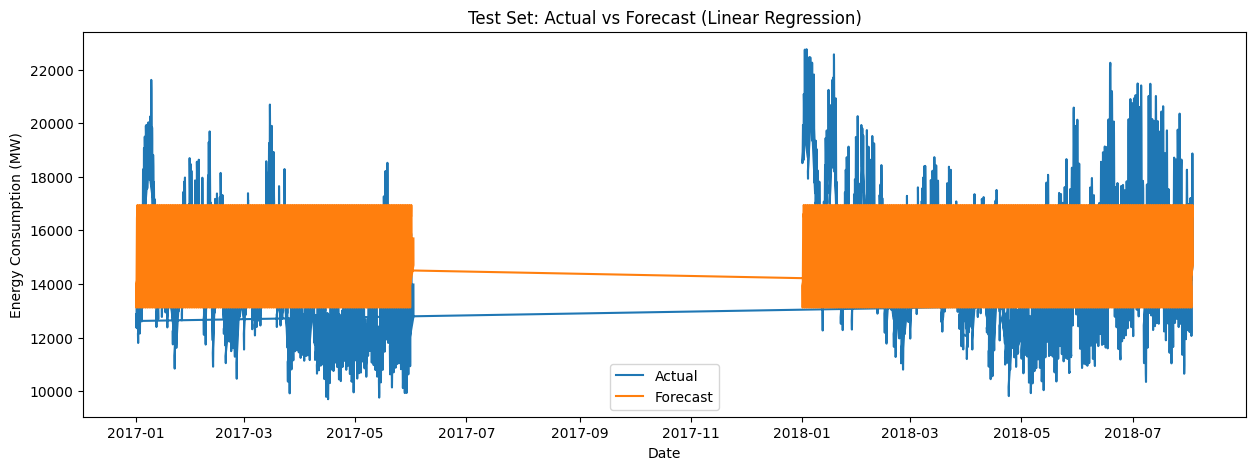

Linear Regression Test MAE: 2012.55880965209
Linear Regression Test RMSE: 2458.342359593546


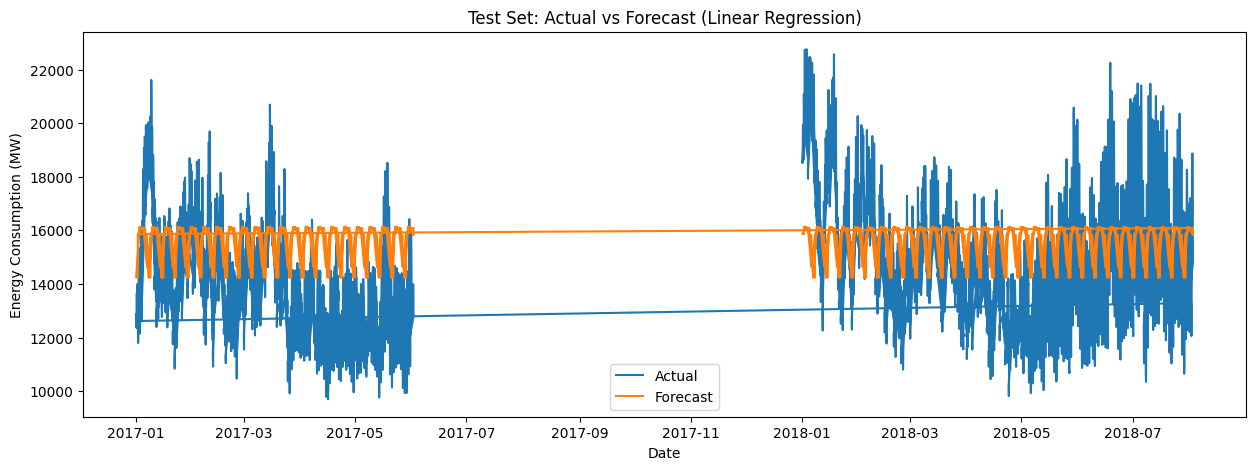

Linear Regression Test MAE: 1942.1203837491678
Linear Regression Test RMSE: 2399.660513082229


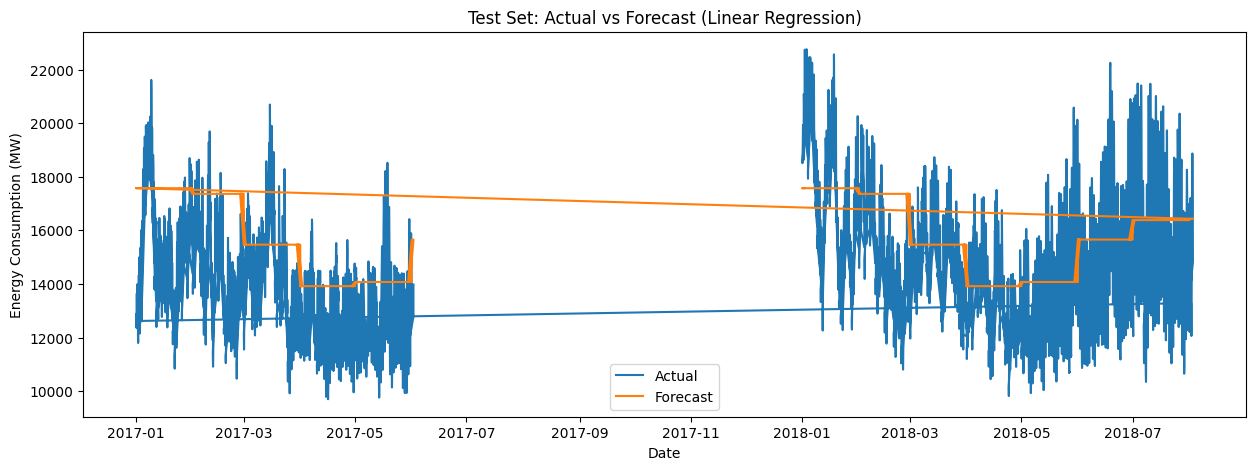

In [21]:
# Для сохранения оценок
mae_list = []
rmse_list = []

# Добавление дамми-переменных для часа, дня недели и месяца
periods = ['hour', 'dayofweek', 'month']

for dum in range(len(periods)):
  df_dum = df.copy()

  if dum==0:
    df_dum['hour'] = df_dum['ds'].dt.hour
  elif dum==1:
    df_dum['dayofweek'] = df_dum['ds'].dt.dayofweek
  else:
    df_dum['month'] = df_dum['ds'].dt.month

  df_dum = pd.get_dummies(df_dum, columns=[periods[dum]], drop_first=True, dtype=int)

  # Оценка модели
  mae, rmse = linear_reg(df_dum)

  # Сохранение результатов оценки модели
  mae_list.append(mae)
  rmse_list.append(rmse)



In [22]:
mae_dict = {k:v for k,v in zip(['linear_hour', 'linear_dayofweek', 'linear_month'],mae_list)}
rmse_dict = {k:v for k,v in zip(['linear_hour', 'linear_dayofweek', 'linear_month'],rmse_list)}

## Линейная регрессия с лагами

Linear Regression Test MAE: 410.7761528885511
Linear Regression Test RMSE: 581.24127582202


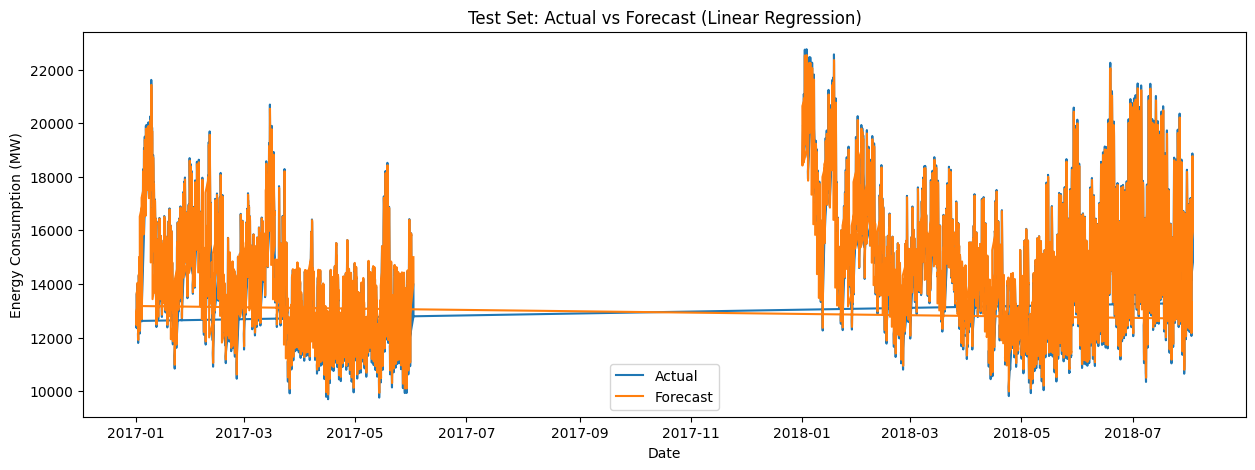

In [23]:
# Создание лаговых переменных
df_lag = df.copy()
df_lag['lag'] = df_lag['y'].shift()

# Оценка модели
mae, rmse = linear_reg(df_lag)

# Запись результатов
mae_dict['linear_lag'] = mae
rmse_dict['linear_lag'] = rmse

## SARIMA

На основании проведённого анализа временного ряда, эксперно будут браться следующие параметры: параметр D для модели SARIMA = 0, q = 3, p = 1.

In [25]:
# Обучение модели SARIMA
model = SARIMAX(train['y'], order=(1, 0, 3), seasonal_order=(1, 1, 1, 12))
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:               112513
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 12)   Log Likelihood             -825633.907
Date:                              Sun, 30 Jun 2024   AIC                        1651281.814
Time:                                      19:39:25   BIC                        1651349.229
Sample:                                           0   HQIC                       1651302.165
                                           - 112513                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9121      0.001    675.741      0.000       0.910       0.915
ma.L1          0.25

In [27]:
# Прогнозирование на тестовой выборке
forecast = results.get_forecast(steps=len(test['y'])).predicted_mean

# Оценка точности модели
sarima_mae = mean_absolute_error(test['y'], forecast)
sarima_rmse = np.sqrt(mean_squared_error(test['y'], forecast))

# Запись результатов
mae_dict['sarima'] = sarima_mae
rmse_dict['sarima'] = sarima_rmse

## Prophet

In [28]:
# Обучение модели Prophet
model = Prophet()
model.fit(train)

# Создание DataFrame для прогнозов
forecast = model.predict(pd.DataFrame(test['ds']))

# Вывод результатов прогнозов
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw1s3s5k/zsifyumi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw1s3s5k/eagjt8qb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58260', 'data', 'file=/tmp/tmplw1s3s5k/zsifyumi.json', 'init=/tmp/tmplw1s3s5k/eagjt8qb.json', 'output', 'file=/tmp/tmplw1s3s5k/prophet_modelfguhzjdb/prophet_model-20240630194122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:41:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
8755,2018-08-02 20:00:00,17756.084716,15525.777228,19880.278501
8756,2018-08-02 21:00:00,17591.980295,15468.886712,19770.683720
8757,2018-08-02 22:00:00,17089.447039,14805.969450,19152.907164
8758,2018-08-02 23:00:00,16323.898393,14093.767068,18678.880528
8759,2018-08-03 00:00:00,15465.966147,13058.922134,17615.434334


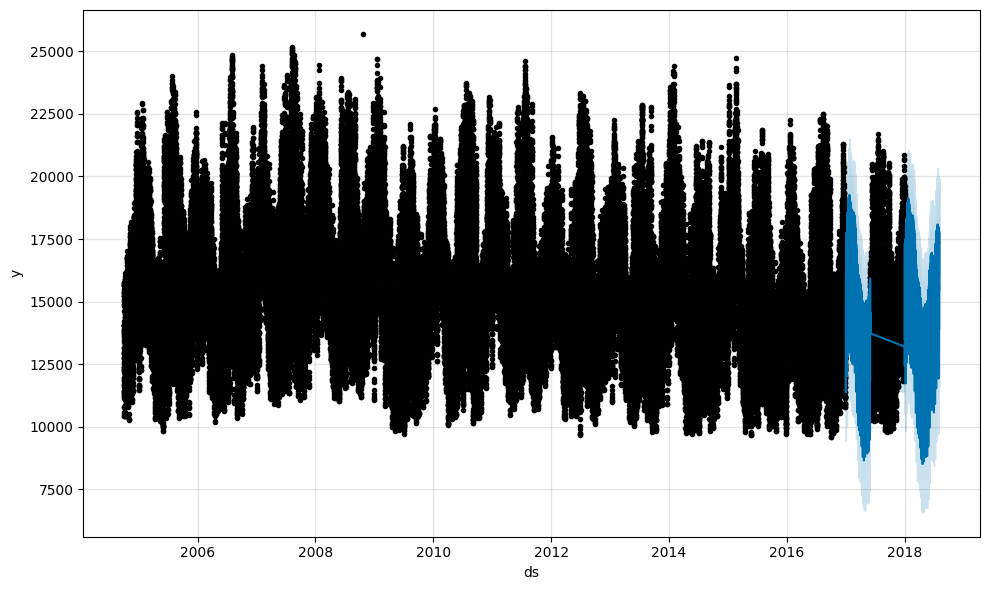

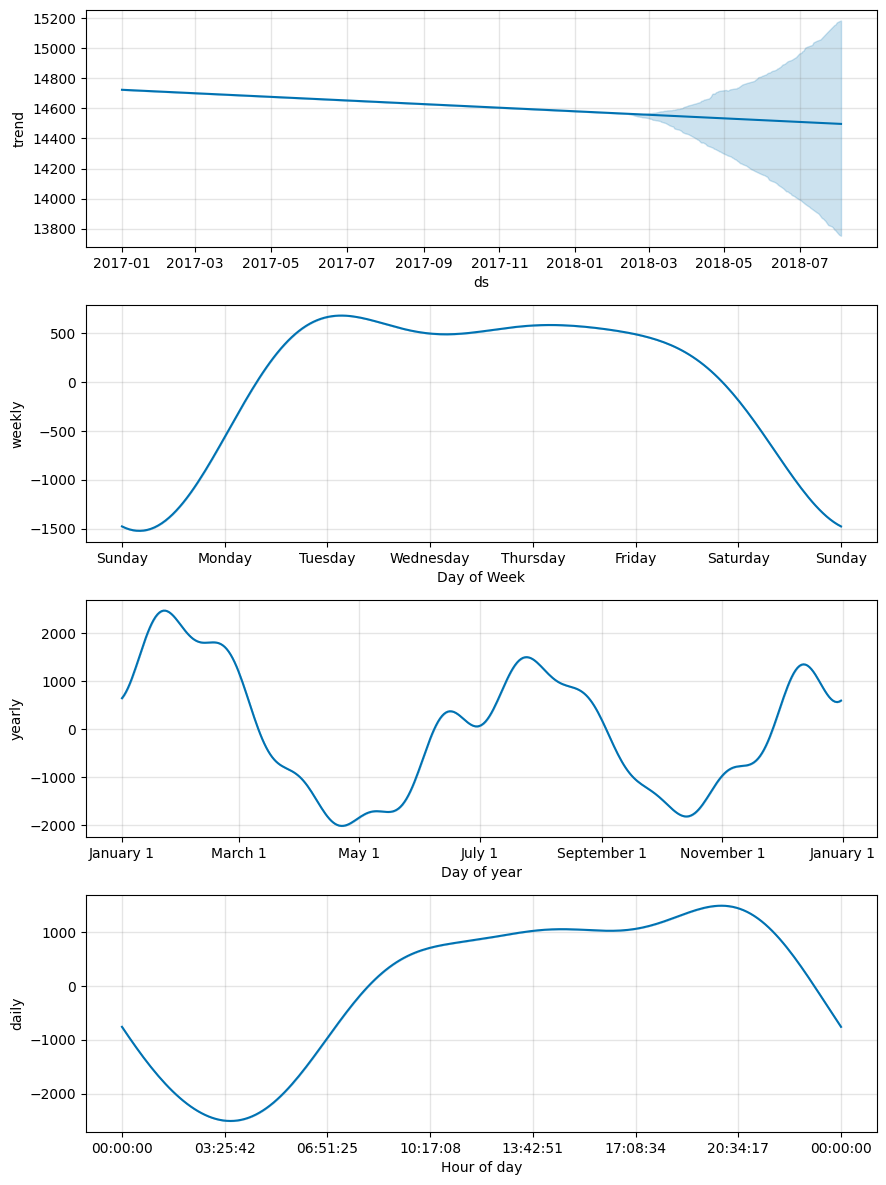

In [29]:
# Построение графиков прогнозов
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)
plt.show()

In [30]:
# Прогнозы Prophet на тестовом наборе
prophet_mae = mean_absolute_error(test['y'], forecast['yhat'])
prophet_rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat']))

print(f'Prophet Test MAE: {prophet_mae}')
print(f'Prophet Test RMSE: {prophet_rmse}')

# Запись результатов
mae_dict['prophet'] = prophet_mae
rmse_dict['prophet'] = prophet_rmse

Prophet Test MAE: 2199.2832816223276
Prophet Test RMSE: 2750.6227379782563


# Сравнение моделей


В рассмотрении будут две метрики: MAE и RMSE. Чем ниже эти метрики, тем модель лучше.


In [31]:
rmse = pd.DataFrame.from_dict(rmse_dict, orient='index', columns=['rmse'])
rmse[rmse['rmse']==rmse.min()[0]]

,rmse
linear_lag,581.241276


In [32]:
mae = pd.DataFrame.from_dict(mae_dict, orient='index', columns=['mae'])
mae[mae['mae']==mae.min()[0]]

,mae
linear_lag,410.776153


# Вывод
В этом проекте был проведён анализ временных рядов, используя библиотеки Prophet и statsmodels. Также было проведено сравнение результатов продвинутых моделей с линейной регрессией, включающей лаговые переменные и дамми-переменные времени.

В результате оценки моделей были получены метрики MAE и RMSE, которые позволили сделать вывод о точности предсказаний каждой модели.

Лучшей моделью для прогнозирования потребления энергии стала обычная линейная модель с лагированными значениями: потребление электроэнергии завтра может быть предсказано на основе потреблении электроэнергии сегодня. Продвинутые модеи могут привнести больше ясности и деталей во временной ряд, но иногла лучший прогноз дают простые модели. Это как раз такой случай.


